Homework #6 Chapter 8: Exercises 8 (except part (f)) and 9

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

In [45]:
# Load the dataset
Carseats = pd.read_csv('Carseats.csv')

High = np.where(Carseats.Sales > 8,
"Yes", "No")


In [46]:
#(a) Split the data set into a training set and a test set.
X = Carseats.drop('Sales', axis=1)
y = Carseats['Sales']

X_dummies = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=20)


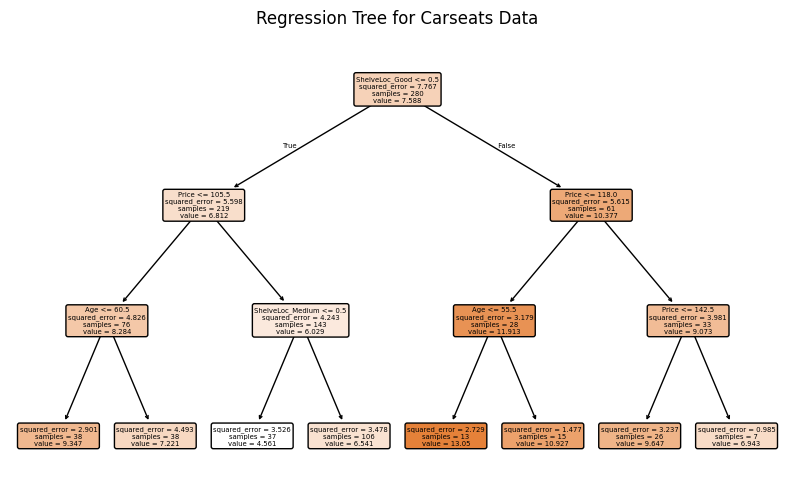

In [47]:
#(b) Fit a regression tree to the training set. Plot the tree, and interpret
#the results. What test MSE do you obtain?
reg_tree = DecisionTreeRegressor(
    max_depth=3, 
    max_features=None, 
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42,
    splitter='best'
)
reg_tree.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plot_tree(reg_tree, filled=True, feature_names=X_dummies.columns, rounded=True)
plt.title("Regression Tree for Carseats Data")
plt.show()

In [48]:
y_pred = reg_tree.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 5.7854


The true branch leads to lower predicted sales (6.812), while the false branch leads to higher predicted sales (10.377). The reduction in squared error from the root node (7.767) to the two branches (5.598 and 5.615) indicates that the splits are effective in reducing the variability of sales predictions.

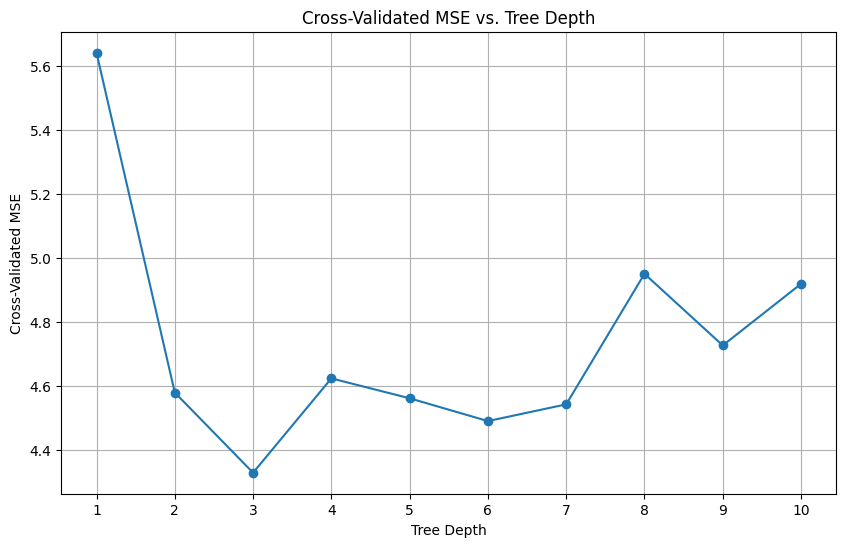

Optimal tree depth: 3
Test MSE for pruned tree: 5.7854
Test MSE for full tree: 5.2056


In [49]:
#(c) Use cross-validation in order to determine the optimal level of tree complexity. 
# Does pruning the tree improve the test MSE?

depths = range(1, 11)
cv_mse = []

for depth in depths:
    reg_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    mse = -cross_val_score(reg_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    cv_mse.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(depths, cv_mse, marker='o')
plt.title('Cross-Validated MSE vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validated MSE')
plt.xticks(depths)
plt.grid()
plt.show()

optimal_depth = depths[np.argmin(cv_mse)]
print(f'Optimal tree depth: {optimal_depth}')

# Step 4: Fit and evaluate the pruned tree
pruned_tree = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
pruned_tree.fit(X_train, y_train)

y_pred_pruned = pruned_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)

full_tree = DecisionTreeRegressor(random_state=42)
full_tree.fit(X_train, y_train)
y_pred_full = full_tree.predict(X_test)
test_mse_full = mean_squared_error(y_test, y_pred_full)

print(f'Test MSE for pruned tree: {test_mse_pruned:.4f}')
print(f'Test MSE for full tree: {test_mse_full:.4f}')

The full tree likely captures more complexity in the dataset, which may lead to overfitting, especially if the tree is too deep or if the data has noise.
The pruned tree, while simpler and potentially more interpretable, may not capture all the important relationships in the data, leading to a higher test MSE.

In [50]:
#(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? 
# Use the feature_importance_ values to determine which variables are most important.
bagging_regressor = BaggingRegressor(
    DecisionTreeRegressor(),
    n_estimators=100, 
    random_state=42
)
bagging_regressor.fit(X_train, y_train)

y_pred_bagging = bagging_regressor.predict(X_test)
test_mse_bagging = mean_squared_error(y_test, y_pred_bagging)

print(f'Test MSE for Bagging Regressor: {test_mse_bagging:.4f}')

importances = np.mean([tree.feature_importances_ for tree in bagging_regressor.estimators_], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': X_dummies.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Test MSE for Bagging Regressor: 3.0833
             Feature  Importance
4              Price    0.295844
7     ShelveLoc_Good    0.272937
0          CompPrice    0.117554
5                Age    0.089567
2        Advertising    0.059032
1             Income    0.051310
8   ShelveLoc_Medium    0.048586
3         Population    0.032261
6          Education    0.023923
10            US_Yes    0.004853
9          Urban_Yes    0.004133


In [51]:
#(e) Use random forests to analyze this data. What test MSE do you obtain? Use the
#  feature_importance_ values to determine which variables are most important. Describe 
# the effect of m, the number of variables considered at each split, on the error rate obtained.
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_features='sqrt',  # Use square root of features at each split
    random_state=42
)
rf_regressor.fit(X_train, y_train)

# Step 5: Make predictions and evaluate test MSE
y_pred_rf = rf_regressor.predict(X_test)
test_mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'Test MSE for Random Forest with max_features="sqrt": {test_mse_rf:.4f}')

feature_importance = rf_regressor.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_dummies.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

Test MSE for Random Forest with max_features="sqrt": 3.4340
Feature Importances:
             Feature  Importance
4              Price    0.227881
7     ShelveLoc_Good    0.211019
5                Age    0.107757
0          CompPrice    0.100701
2        Advertising    0.083148
1             Income    0.083005
3         Population    0.071680
6          Education    0.047814
8   ShelveLoc_Medium    0.041631
10            US_Yes    0.014142
9          Urban_Yes    0.011222


9. This problem involves the OJ data set which is part of the ISLP package.

In [52]:
#(a) Create a training set containing a random sample of 800 observations, and a test 
# set containing the remaining observations.

oj_data = pd.read_csv('OJ.csv')

train_data, test_data = train_test_split(oj_data, train_size=800, random_state=42)

print(f'Training set size: {len(train_data)}')
print(f'Test set size: {len(test_data)}')

Training set size: 800
Test set size: 270


In [53]:
#(b) Fit a tree to the training data, with Purchase as the response 
#and the other variables as predictors. What is the training error rate?
train_data['Purchase'] = train_data['Purchase'].map({'CH': 1, 'MM': 0})  # Convert to binary
train_data = pd.get_dummies(train_data, columns=['Store7'], drop_first=True)
X_train = train_data.drop('Purchase', axis=1)  # Features
y_train = train_data['Purchase']  # Target

# Step 4: Fit a decision tree classifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
clf.fit(X_train, y_train)

# Step 5: Make predictions on the training data
y_train_pred = clf.predict(X_train)

# Step 6: Calculate the training error rate
training_accuracy = accuracy_score(y_train, y_train_pred)
training_error_rate = 1 - training_accuracy

print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Training Error Rate: {training_error_rate:.4f}")

Training Accuracy: 0.8475
Training Error Rate: 0.1525


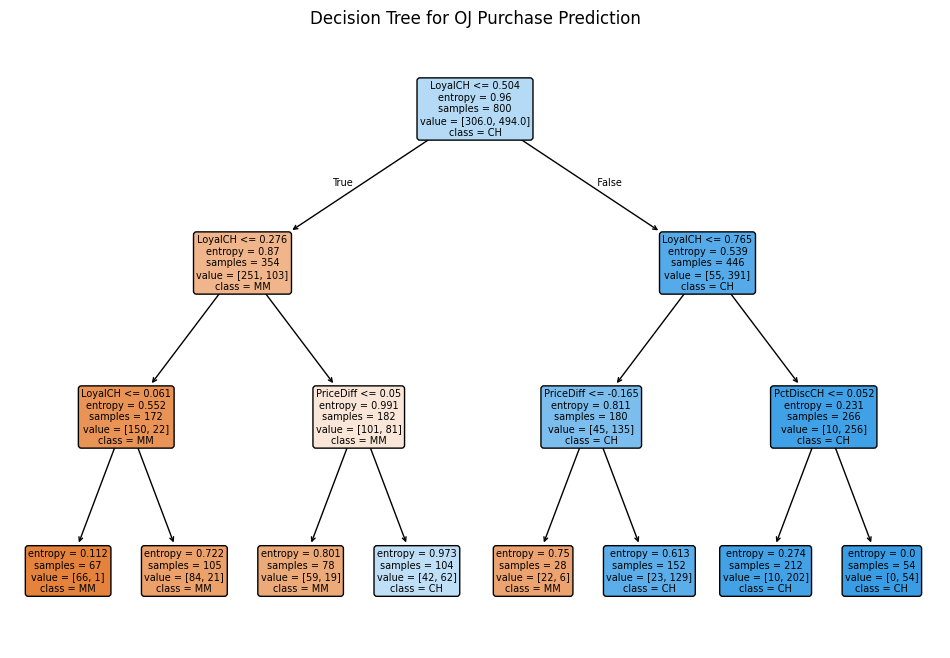

Number of terminal nodes (leaf nodes): 8


In [54]:
#(c) Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['MM', 'CH'], rounded=True)
plt.title('Decision Tree for OJ Purchase Prediction')
plt.show()

# Step 8: Count the number of terminal nodes
n_terminal_nodes = clf.get_n_leaves()
print(f"Number of terminal nodes (leaf nodes): {n_terminal_nodes}")

In [58]:
#(d) Use the export_tree() function to produce a text summary of the fitted tree. Pick one of the terminal nodes, 
# and interpret the information displayed.
tree_text = export_text(clf, feature_names=list(X_train.columns), show_weights= True)
print(tree_text)

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- weights: [66.00, 1.00] class: 0
|   |   |--- LoyalCH >  0.06
|   |   |   |--- weights: [84.00, 21.00] class: 0
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [59.00, 19.00] class: 0
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [42.00, 62.00] class: 1
|--- LoyalCH >  0.50
|   |--- LoyalCH <= 0.76
|   |   |--- PriceDiff <= -0.16
|   |   |   |--- weights: [22.00, 6.00] class: 0
|   |   |--- PriceDiff >  -0.16
|   |   |   |--- weights: [23.00, 129.00] class: 1
|   |--- LoyalCH >  0.76
|   |   |--- PctDiscCH <= 0.05
|   |   |   |--- weights: [10.00, 202.00] class: 1
|   |   |--- PctDiscCH >  0.05
|   |   |   |--- weights: [0.00, 54.00] class: 1



In [ ]:
from sklearn.metrics import confusion_matrix

In [59]:
#(e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted
#  test labels. What is the test error rate?
test_data['Purchase'] = test_data['Purchase'].map({'CH': 1, 'MM': 0})
test_data = pd.get_dummies(test_data, columns=['Store7'], drop_first=True)

# Align test data columns with training data
X_test = test_data.drop('Purchase', axis=1)
y_test = test_data['Purchase']

# Make predictions on the test data
y_test_pred = clf.predict(X_test)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error_rate = 1 - test_accuracy

# Print the accuracy and test error rate
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

# Generate and display the confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(confusion)


Test Accuracy: 0.8037
Test Error Rate: 0.1963
Confusion Matrix:
[[ 72  39]
 [ 14 145]]


In [62]:
#(f) Use cross-validation on the training set in order to determine the optimal tree size.
max_depths = range(1, 11)  # Testing depths from 1 to 10
cv_scores = []

# Step 5: Perform cross-validation for each max depth
for depth in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    scores = cross_val_score(clf, X_train, y_train, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())  # Store the mean score

# Step 6: Find the optimal depth
optimal_depth = max_depths[np.argmax(cv_scores)]
print(f"Optimal tree depth: {optimal_depth}")


Optimal tree depth: 4


In [ ]:
from sklearn import model_selection as skm


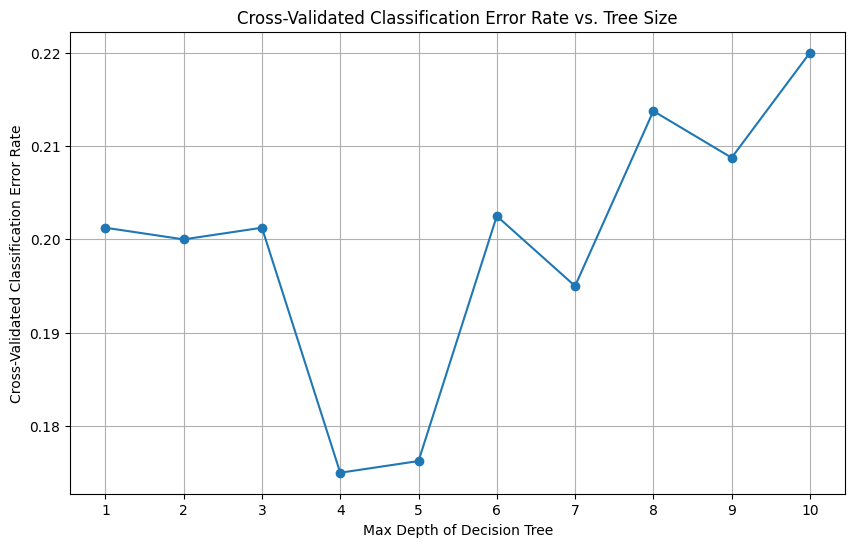

In [63]:
#(g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.
cv_error_rates = [1 - score for score in cv_scores]

# Step 7: Plot error rates against tree sizes
plt.figure(figsize=(10, 6))
plt.plot(max_depths, cv_error_rates, marker='o')
plt.title('Cross-Validated Classification Error Rate vs. Tree Size')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.xticks(max_depths)
plt.grid()
plt.show()

(h) Which tree size corresponds to the lowest cross-validated classification error rate?
4

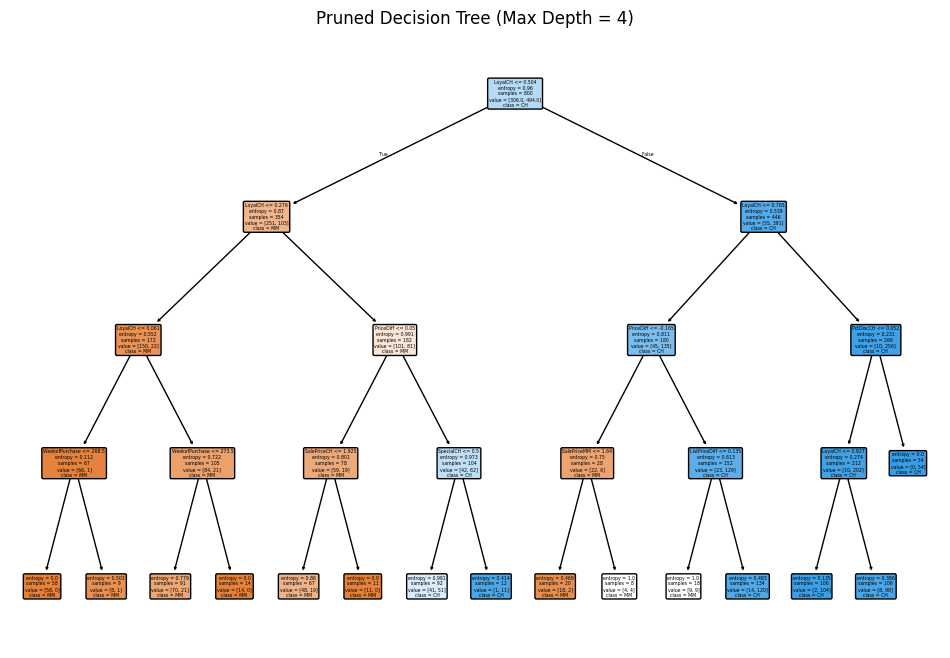

In [64]:
#(i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation
# does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.
pruned_tree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_depth, random_state=0)
pruned_tree.fit(X_train, y_train)

# Step 8: Plot the pruned tree
plt.figure(figsize=(12, 8))
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns, class_names=['MM', 'CH'], rounded=True)
plt.title(f'Pruned Decision Tree (Max Depth = {optimal_depth})')
plt.show()

In [66]:
#(j) Compare the training error rates between the pruned and unpruned trees. Which is higher?
y_train_pred_pruned = pruned_tree.predict(X_train)
training_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
training_error_rate_pruned = 1 - training_accuracy_pruned

# Step 9: Compare training error rates
print(f"Training Error Rate (Unpruned Tree): {training_error_rate:.5f}")
print(f"Training Error Rate (Pruned Tree): {training_error_rate_pruned:.5f}")

Training Error Rate (Unpruned Tree): 0.15250
Training Error Rate (Pruned Tree): 0.15250
